# Tweet Analysis and Sentiment Classfication

This project focusses on analysing the tweets of John Siracusa -Programmer, tech writer, and co-host of Accidental Tech Podcast. The data is available in .json format(around 3000 tweets) 

Goals:
### Tweet Analysis
- Analysing Tweet growth over days
- Most popular tweet
- Most popular words and hastags
- Co-occuring terms

### Sentiment Classification of tweets (postive or negative) using stanford large movie dataset

Classifying the tweets by traiing the model using the stanford large movie review datset. http://ai.stanford.edu/~amaas/data/sentiment/
This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided. 
Dataset - The core dataset contains 50,000 reviews split evenly into 25k trainand 25k est sets. The overall distribution of labels is balanced (25kpos and 25k neg). 

### Topic modeling using LDA
Using genism library



In [125]:
import ggplot
from ggplot import *
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import json
from pandas.io.json import json_normalize

import os,codecs
import string
import operator

from collections import Counter,defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,TweetTokenizer,sent_tokenize
from nltk.stem.porter import PorterStemmer

from gensim import corpora,models
import gensim

from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import time
from sklearn.metrics import roc_curve


In [196]:
sirac = pd.read_json('data/new_siracusa_tweets.json')

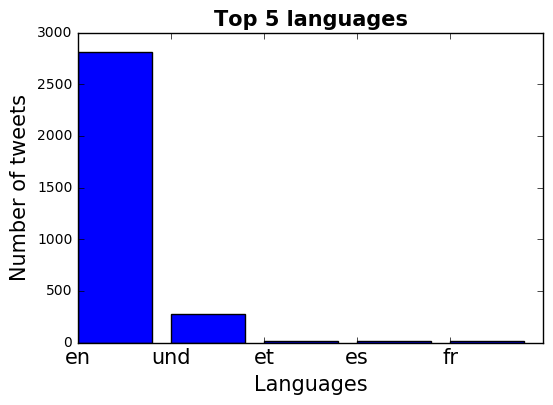

In [4]:
tweets_by_lang = sirac['lang'].value_counts()
tweets_by_lang
fig, ax = plt.subplots()
ax.bar(range(5),tweets_by_lang[:5])
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
ax.set_xticklabels(tweets_by_lang.index[:5],fontsize=15)
plt.show()


### No. of original tweets and retweets 

In [5]:
list_of_original_tweets = [element for element in sirac['text'].values if not element.startswith('RT')]
print "Number of Original Tweets : " + str(len(list_of_original_tweets))



Number of Original Tweets : 2560


In [6]:
list_of_retweets = [element for element in sirac['text'].values if element.startswith('RT')]
print "Number of Retweets : " + str(len(list_of_retweets))


Number of Retweets : 656


### Most retweeted tweet

In [7]:
src = pd.DataFrame(sirac['retweet_count'].values).dropna()
sirac['text'][src.idxmax().values]


2205    RT @notch: We were in talks about maybe bringi...
Name: text, dtype: object

In [8]:
print "Most popular tweet is " ,sirac.iloc[2205]['text']

Most popular tweet is  RT @notch: We were in talks about maybe bringing a version of Minecraft to Oculus. I just cancelled that deal. Facebook creeps me out.


### Tweet growth over days

In [9]:
df = pd.DataFrame(sirac['created_at'].value_counts())
df['date'] = df.index
df.columns = ['Num of tweets','date']

In [10]:
days = [str(item).split("T")[0] for item in df['date'].values]
df['days'] = days
tweet_growth = df[['days', 'Num of tweets']].groupby('days').sum()
tweet_growth['days']= tweet_growth.index
tweet_growth.head()

,Num of tweets,days
days,,
2014-02-10,14,2014-02-10
2014-02-11,50,2014-02-11
2014-02-12,4,2014-02-12
2014-02-13,33,2014-02-13
2014-02-14,13,2014-02-14


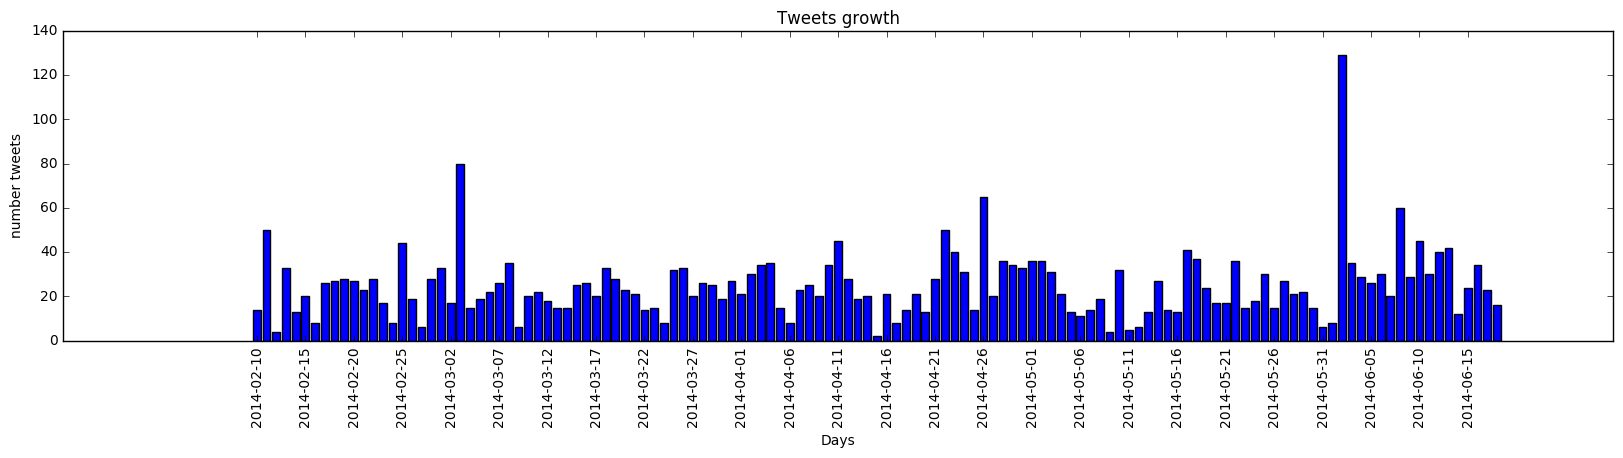

In [11]:
import numpy as np
fig, ax = plt.subplots(1,figsize=(20,4))
x_pos = np.arange(len(tweet_growth['days'].values))
ax.bar(x_pos, tweet_growth['Num of tweets'].values, align='center')
ax.set_xticks(x_pos[0:len(tweet_growth):5])
ax.set_title('Tweets growth')
ax.set_ylabel("number tweets")
ax.set_xlabel("Days")
ax.set_xticklabels(tweet_growth['days'].values[0:len(tweet_growth):5],rotation = 90)
plt.show()

#### Preprocessing the data
Processing the data by removing tags,stopwords,punctuation.

In [98]:
p_stemmer = PorterStemmer()
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']
tknz = TweetTokenizer()

def preprocess_data(tweet):
    count_all = Counter()
    count_hash = Counter()
    count_term_only = Counter()
    term_tot=[]

    for tw in tweet:
        t = tw['text'].encode('ascii','ignore').lower()
        # Create a list with all the terms
        terms_all  = [term for term in tknz.tokenize(t) if term not in stop]

        # Count hashtags only
        terms_hash = [term for term in tknz.tokenize(t) if term.startswith('#')]
        
        # Count terms only (no hashtags, no mentions, no urls)
        terms_only = [term for term in tknz.tokenize(t) if term not in stop and not term.startswith(('#', '@'))]     
        
        #stem token
        #stem_terms_only = [p_stemmer.stem(i) for i in terms_only]
        term_tot.append(' '.join(terms_only))

        # Update the counter
        count_all.update(terms_all)
        count_hash.update(terms_hash)
        count_term_only.update(terms_only)
    return count_all,count_hash,count_term_only,term_tot 

#Eg:
#print tweet[0]['text']
#print word_tokenize(tweet[0]['text']) 
#print tknz.tokenize(tweet[0]['text'])

In [99]:
#load json as string
tweet = json.load((codecs.open('./new_siracusa_tweets.json', "r","utf-8")))
count_all,count_hash,count_term_only,term_tot  = preprocess_data(tweet)

### Most frequent terms [no hastag/ no mentions ]

In [100]:
count_term_only.most_common(10)

[(u'like', 168),
 (u"it's", 154),
 (u"don't", 136),
 (u'think', 124),
 (u"i'm", 110),
 (u'one', 109),
 (u'yes', 109),
 (u'also', 89),
 (u'apple', 86),
 (u'maybe', 83)]

### Most frequent hash tags

In [101]:
count_hash.most_common(10)

[(u'#', 6),
 (u'#yesallwomen', 4),
 (u'#oscars', 4),
 (u'#wwdc', 3),
 (u'#swift', 2),
 (u'#wwdc14', 2),
 (u'#134', 1),
 (u'#yesall', 1),
 (u'#topical', 1),
 (u'#poopchanger', 1)]

### Co-occurence Words

In [102]:
def create_comat(tweet,sentimentFlag):
    com = defaultdict(lambda : defaultdict(int))

    for t in term_tot:
        terms_only = t.split( )
        # Build co-occurrence matrix
        for i in range(len(terms_only)-1):            
            for j in range(i+1, len(terms_only)):
                w1, w2 = sorted([terms_only[i], terms_only[j]])                
                if w1 != w2:
                    com[w1][w2] += 1
    return com                

In [103]:
com = create_comat(tweet,0)
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
terms_max[:10]

[((u"don't", u'know'), 32),
 ((u"don't", u'think'), 24),
 ((u"i'm", u'sure'), 23),
 ((u"don't", u'like'), 18),
 ((u'1', u'2'), 16),
 ((u'os', u'x'), 16),
 ((u'star', u'wars'), 15),
 ((u"it's", u'like'), 14),
 ((u':/', u'http'), 13),
 ((u"haven't", u'yet'), 13)]

### Sentiment Classification of tweets (postive or negative) using stanford large movie dataset




### Creating training model using the stanford movie dataset. 

In [22]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation

basedir = './aclImdb/'
trainDir = basedir + 'train/'
testDir = basedir + 'test/'
categories = ['pos','neg']

def make_xy(inputDir,categories):
    X = []
    Y= []
    for ind,cat  in enumerate(categories):
        currentDir  = inputDir + cat
        files  = os.listdir(currentDir)
        for f in files:
            f = codecs.open(currentDir + '/' + f, 'r','iso8859-1')
            if f:
                content = f.read().lower()
                sen = sent_tokenize(content)
                tokens = word_tokenize(str(sen))
                tokens_no_sw = [token for token in tokens if token not in stop]

                X.append(' '.join(tokens_no_sw))
                Y.append(ind)
    return X,Y        

In [23]:
X_train_data,Y_train_data = make_xy(trainDir,categories)


In [24]:
X_test_data,Y_test_data = make_xy(testDir,categories)

### Features - Tf-IDf model 
The naive bag of words model can provide moderate results as it assumpes independence of all the words in the review and does not take word order into account.Hence the model used here is Tf-Idf which asisgns weight to evry word based on its frequecy in the other documents. This way we consider rare words more relevant.

##### Addressing the Overfitting
It was observed that reducing the feature set to 5000 reduced the overfitting in the training data significantly  while preserving the test accuarcy. So the max_features set is set to 5000. Also using bigrams with unigrams gave better classification scores.  

In [88]:
vectorizer = TfidfVectorizer(ngram_range= (1, 2),max_features=5000,min_df=1)
X_train = vectorizer.fit_transform(X_train_data)
X_test = vectorizer.transform(X_test_data)

Y_train = np.array(Y_train_data)
Y_test = np.array(Y_test_data)



### Classification Models and Results

I have used 3 different classification models here for this binary classification problem:
- Naiye Bayes
- Logistic Regression
- Random Forest

I did not opt for Kernelized SVMs as it require the computation of a distance function between each point in the dataset, which is the dominating cost of O(nfeatures×n2observations) and our datast is large. The storage of the distances is a burden on memory, so they're recomputed on the fly. .

- Logistic regression seems to perform best in terms of training score of 91.75%, test score of 88.48% and area under the ROC curve. Time to train the model is around 700ms and prediction time is negligible. 
- Naive Bayes perforemed second best. Train score - 87.1% and test score - 85.1%
- Random forest parameters needed tuning else the default model resulted in overfitting. It performed the worst in terms of score,time and area under the curve.



In [89]:
nb_clf  = MultinomialNB(alpha = 1)
log_clf = LogisticRegression(C=1)
rf_clf  =  RandomForestClassifier(n_estimators=50,max_depth = 20,min_samples_leaf=2)
clfs = [
    ("MultinomialNB", nb_clf),
    ("LogisticRegression", log_clf),
    ("RandomForestClassifier", rf_clf)
]

all_results = None
for name, clf in clfs:
    tStart = time.time()
    clf.fit(X_train, Y_train)
    tEnd = time.time()
    train_time = tEnd - tStart
    
    tStart=time.time()
    probs = clf.predict_proba(X_test)[:,1]
    tEnd=time.time()
    predict_time = tEnd - tStart
    
    fpr, tpr, thresh = roc_curve(Y_test, probs)
    train_score = clf.score(X_train, Y_train)
    test_score = clf.score(X_test, Y_test)
    
    results = pd.DataFrame({
        "name": name,
        "train time": train_time,
        "predict time":predict_time,
        "fpr": fpr,
        "tpr": tpr,
        "train score":train_score,
        "test score": test_score
    })
    if all_results is None:
        all_results = results
    else:
        all_results = all_results.append(results)

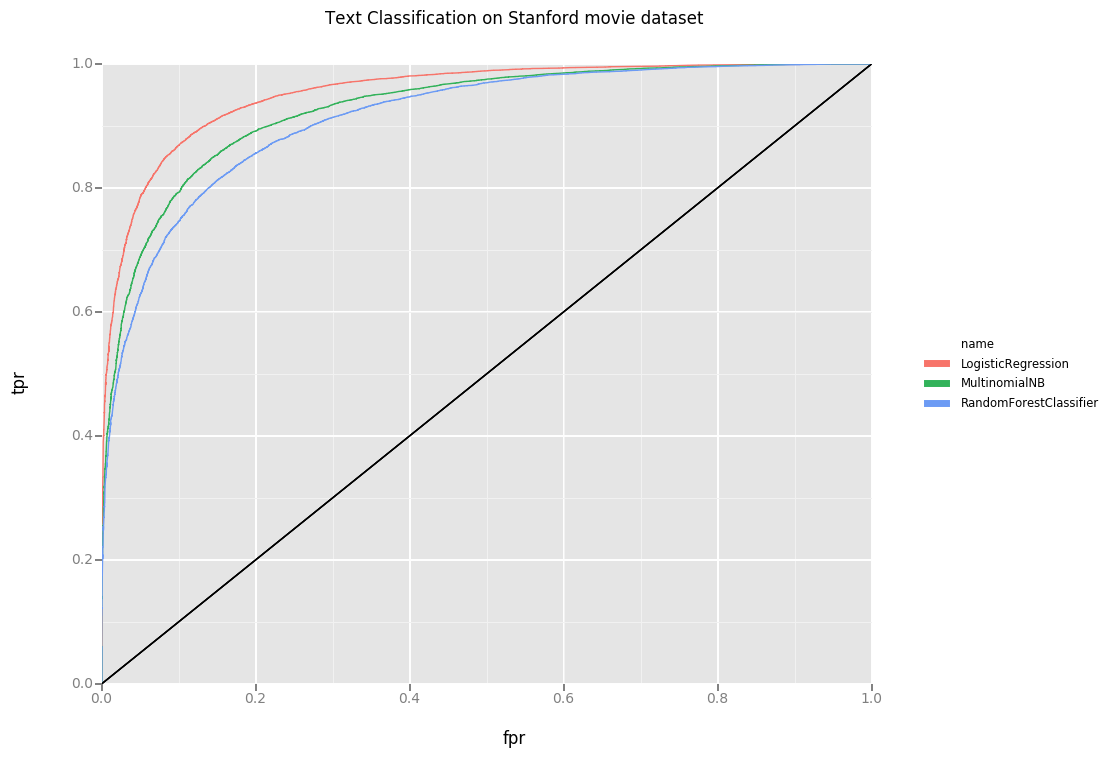

<ggplot: (39125466)>

In [90]:
ggplot(aes(x='fpr', y='tpr', color='name'), data=all_results) + \
    geom_line() + \
    geom_abline(color="black") + \
    ggtitle("Text Classification on Stanford movie dataset")

In [91]:
all_results[['train score', 'test score','train time','predict time']].groupby(all_results.name).mean()

,train score,test score,train time,predict time
name,,,,
LogisticRegression,0.91744,0.88428,0.687,0.016
MultinomialNB,0.87148,0.85148,0.031,0.016
RandomForestClassifier,0.90656,0.82936,5.807,0.486


### Classifying the tweets as postive or negative

#### Using the logistic reression model above

In [92]:
tw_data = vectorizer.transform(term_tot)
tw_predict_class = log_clf.predict(tw_data)
tw_result = pd.DataFrame({ 'tweet':sirac['text'][50:].values,'Sentiment': tw_predict_class[50:]})


In [166]:
pd.options.display.max_colwidth  # default is 50
pd.set_option('display.max_colwidth', 200)
tw_result

,Sentiment,tweet
0,0,"Similar, but smaller scale: kart customization UI in MK8 is more cumbersome than it was in DD."
1,1,Pikmin 3's GamePad control scheme feels like a punishment. Even the GC control scheme feels more efficient.
2,0,@johnsiracusa Humor.
3,1,@jsnell Madness. Think of the poor trash can!
4,1,"@settern One star. Leaves never changed color, fell."
5,0,"@Spacekatgal The PS3 version looks amazing. No need to wait for PS4, I think (though I'll get the PS4 version for longevity anyway)."
6,1,"@Spacekatgal If ever there was a last name that sounds like a good fit for an alien. (Is the president an alien? Wait, don't tell me…)"
7,1,"@Spacekatgal @jsnell @langsharpe Still too lazy to Google, but from my Twitter feed: https://t.co/OCfydsp0cW"
8,0,"@drance @pavanrajam @reneritchie @chockenberry @caseyliss Both California accent things, I think."
9,1,"@reneritchie I think that's just an accent, like @hotdogsladies's ""may-sure"" (measure)."


## Topic modeling using LDA

In [148]:
pos=["IN","CC","RB","CD","MD"]
texts=[]
for term in term_tot:
    nn= nltk.pos_tag(term.split())
    dt_tags = [t[0] for t in nn if t[1] != pos]
    texts.append(dt_tags)

In [192]:
#turn tokenized documents into id term dictionary

texts = [term.split() for term in term_tot]
dictionary = corpora.Dictionary(texts)

#turn tokenized documents into document term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

#generate lda model
ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=5, id2word=dictionary, passes=50)

In [197]:
print(ldamodel.print_topics(num_topics=5, num_words=10))

[(0, u'0.017*"don\'t" + 0.015*"it\'s" + 0.009*"i\'m" + 0.007*"also" + 0.007*"think" + 0.006*"like" + 0.006*"know" + 0.005*"live" + 0.005*"maybe" + 0.005*"apple"'), (1, u'0.011*"maybe" + 0.010*"like" + 0.006*"ios" + 0.005*"one" + 0.005*"really" + 0.005*"probably" + 0.005*"got" + 0.004*"you\'d" + 0.004*"though" + 0.004*"video"'), (2, u'0.020*"yes" + 0.007*"think" + 0.007*"never" + 0.006*"know" + 0.006*"like" + 0.006*"don\'t" + 0.005*"it\'s" + 0.005*"read" + 0.005*"yet" + 0.005*"way"'), (3, u'0.006*"people" + 0.005*"game" + 0.005*"think" + 0.005*"like" + 0.004*"show" + 0.004*"one" + 0.004*"thanks" + 0.004*"movie" + 0.003*"get" + 0.003*"also"'), (4, u'0.008*"good" + 0.006*"one" + 0.006*"like" + 0.005*"time" + 0.004*"even" + 0.004*"name" + 0.004*"apple" + 0.004*"i\'m" + 0.004*"mean" + 0.003*"things"')]


### Conclusions
- Tweet analysis over a period of 2014-02-10 to 2014-06-09 for John Siracusa is carried out.
    - Number of Original Tweets : 2560
    - Number of retweets - 656
    - Maximum number of tweets ooccured on 05-02-2014
    - Most frequent has-tag included #yesallwomen,#oscars,'#wwdc
    - Most frequent co-occuring word ("don't", 'know'),("don't",'think'),('os', 'x'),('star','wars') 
 
 
 - Sentiment Classification of tweets was performed by training the model using stanford large movie datset
    - Logistic regression with tf-idf performed best with training accuracy of 88.42%.
        - This result is very close to state of art result on this datset.  
          http://www.aclweb.org/anthology/W14-2621 N-grams + RbF [91.60 ,89.87]
        - Using very simple model like logistic regression we got train and test accuracy  of [91.74, 88.42]
        - It was discovered that the accuracy of model depends primarily on feature extraction models.
    - Trained model was then used to classify tweets with positive or negative sentiment     
    - It should be noticed that not all tweets have positive or negative sentiment. Some tweets are neutral. For such classification we will have to train the model with one more class-'neutral' (3 classes in total).
    
- Topic modeling on tweets was carried using genism library  
    - This need some more work like applying Part of Speech Tag Filter.
